In [2]:
%load_ext autoreload
%autoreload 2

In [36]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)

no filter


/Library/Python/2.7/site-packages/pygraphviz/agraph.py:1281: RuntimeWarning: Fontconfig warning: ignoring UTF-8: not a valid region tag

  warnings.warn("".join(errors),RuntimeWarning)


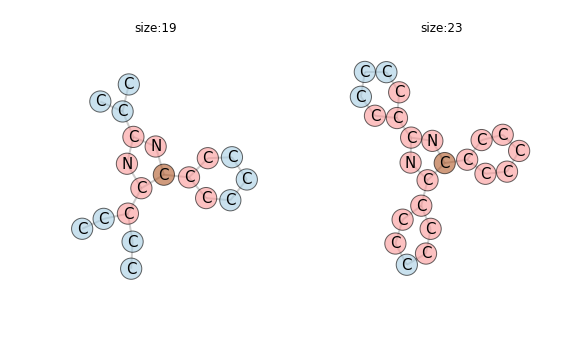

with filter: nothing should appear,,,
with filter but we chose node 2 as root


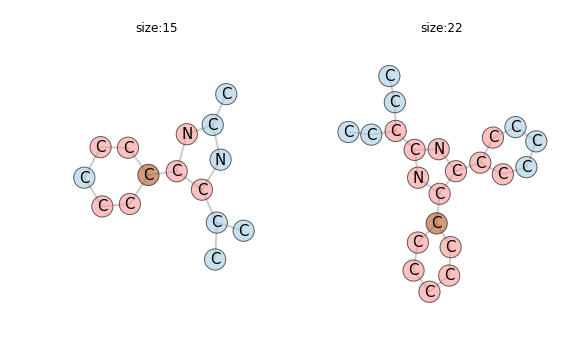

with filter but node "0" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up


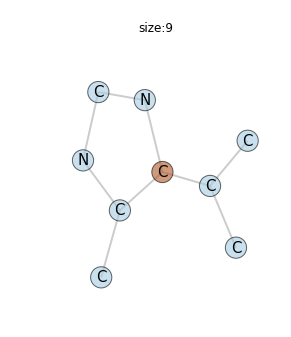

In [4]:
'''
first we test the core/interface extractor, since it is most essential
'''
import sys
sys.path.append('..')
%matplotlib inline
from eden.converter.graph.gspan import gspan_to_eden
from graphlearn import graphtools as gt
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl

#get a graph
gr = gspan_to_eden( 'bursi.pos.gspan' )
g=gr.next()

def mark_and_draw(a):
    ng=myutils.cip_to_graph(a)
    myutils.draw_graph_set(ng, 
                           n_graphs_per_line=7, size=5, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)
    
g.node[1]['no_root']=True

#lets see.. without filter:
a=gl.extract_core_and_interface(1,g,radius_list=[2,4],thickness_list=[2],vectorizer=eg.Vectorizer())
print 'no filter'
mark_and_draw(a)


# lets do the same but with the filter
a=gl.extract_core_and_interface(1,g,radius_list=[2,4],thickness_list=[2],vectorizer=eg.Vectorizer(),filter=gt.filter)
print 'with filter: nothing should appear,,,'
mark_and_draw(a)

# filter is ignoring unfiltered things:
a=gl.extract_core_and_interface(2,g,radius_list=[2,4],thickness_list=[2],vectorizer=eg.Vectorizer(),filter=gt.filter)
print 'with filter but we chose node 2 as root'
mark_and_draw(a)


# no core attribute
g.node[0]["not_in_core"]=True
g.node[1].pop('no_root')
a=gl.extract_core_and_interface(1,g,radius_list=[0,2],thickness_list=[2],vectorizer=eg.Vectorizer(),filter=gt.filter)
print 'with filter but node "0" cant be part of a core, we gave 0 and 2 as radius list and only radius 2 will show up'
mark_and_draw(a)


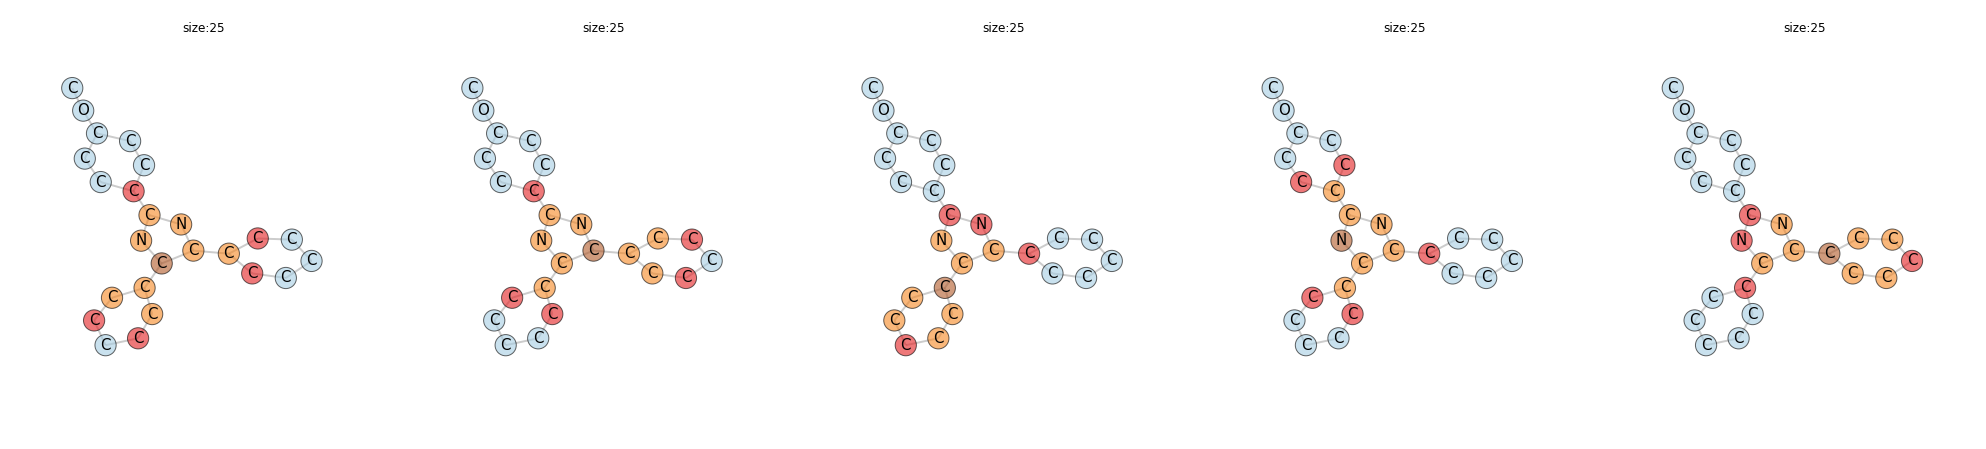

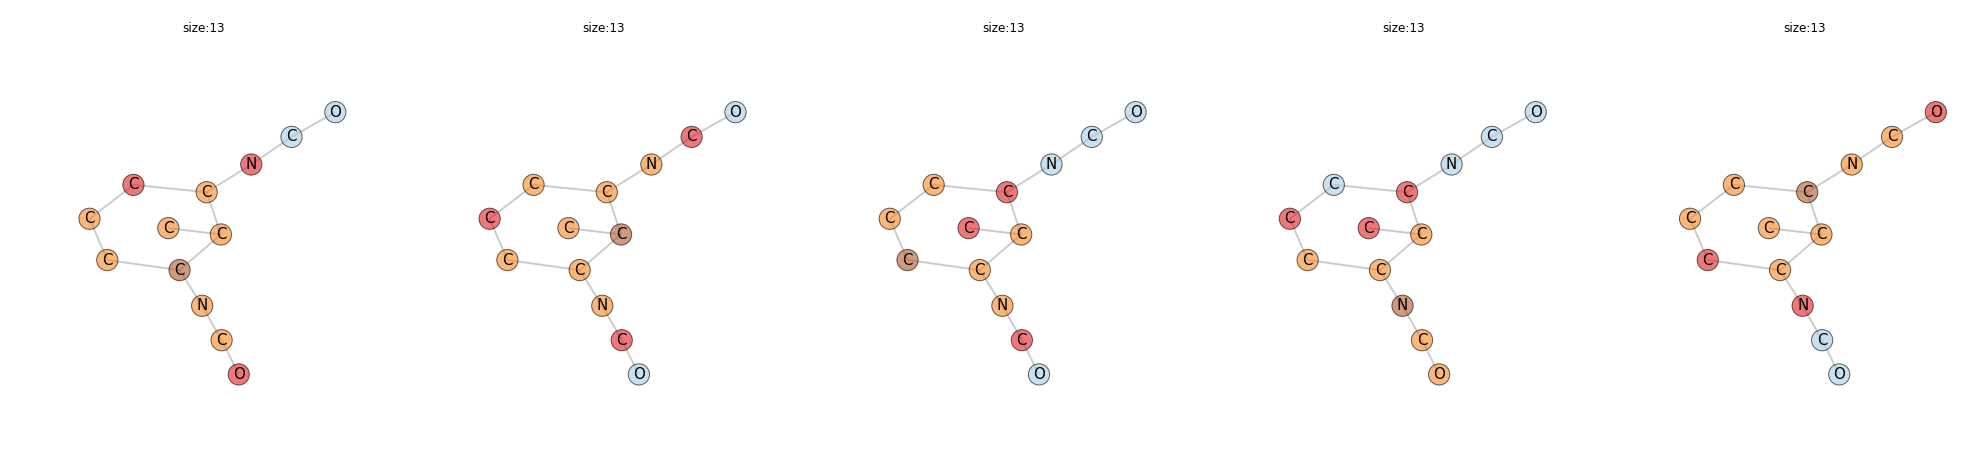

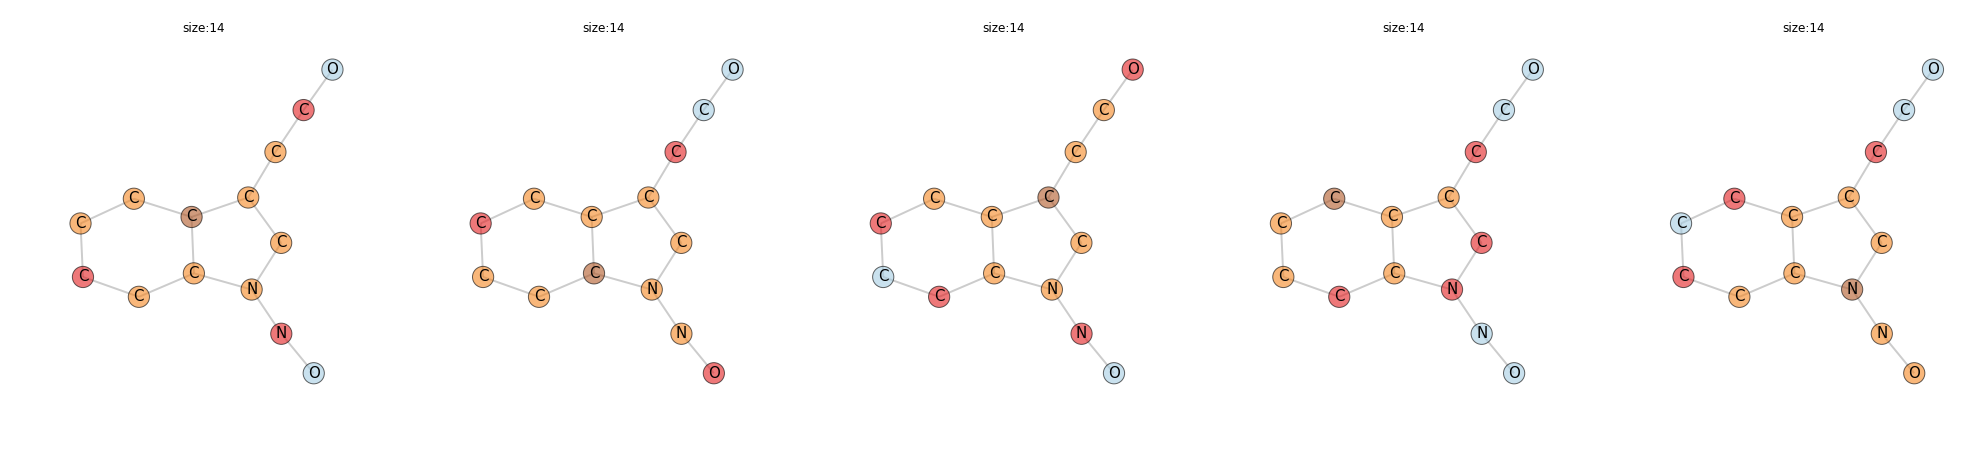

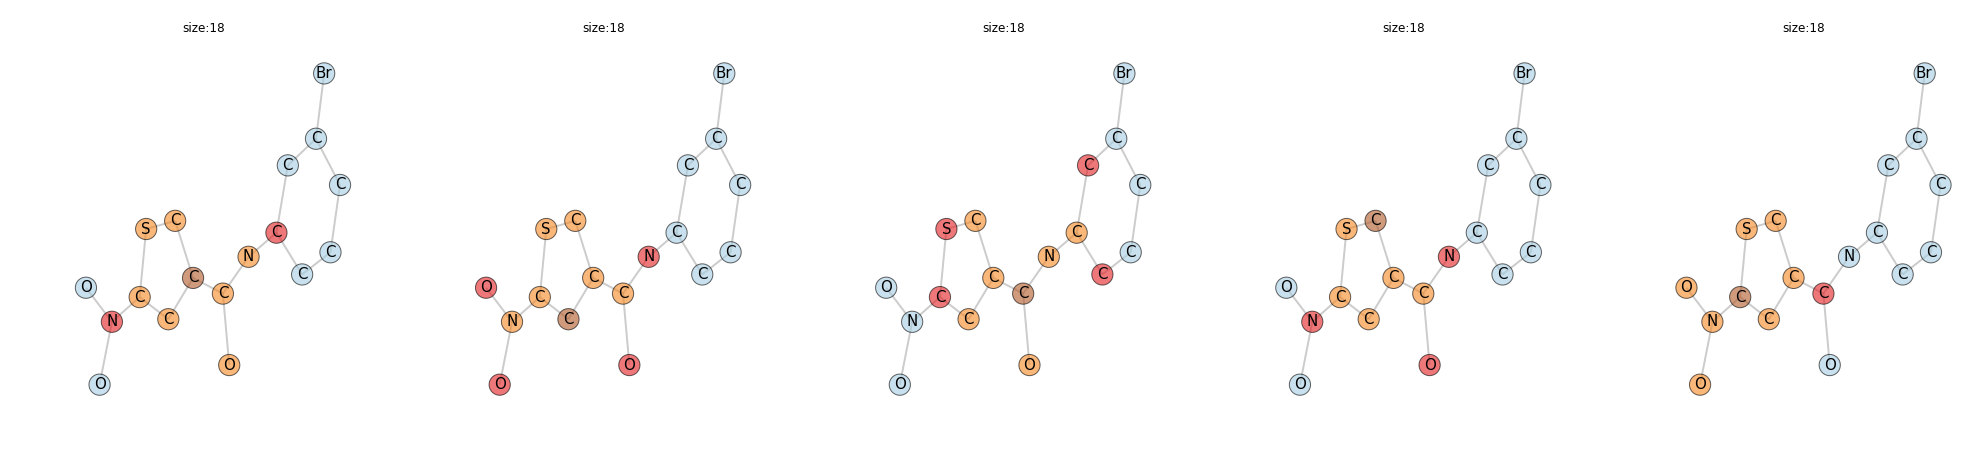

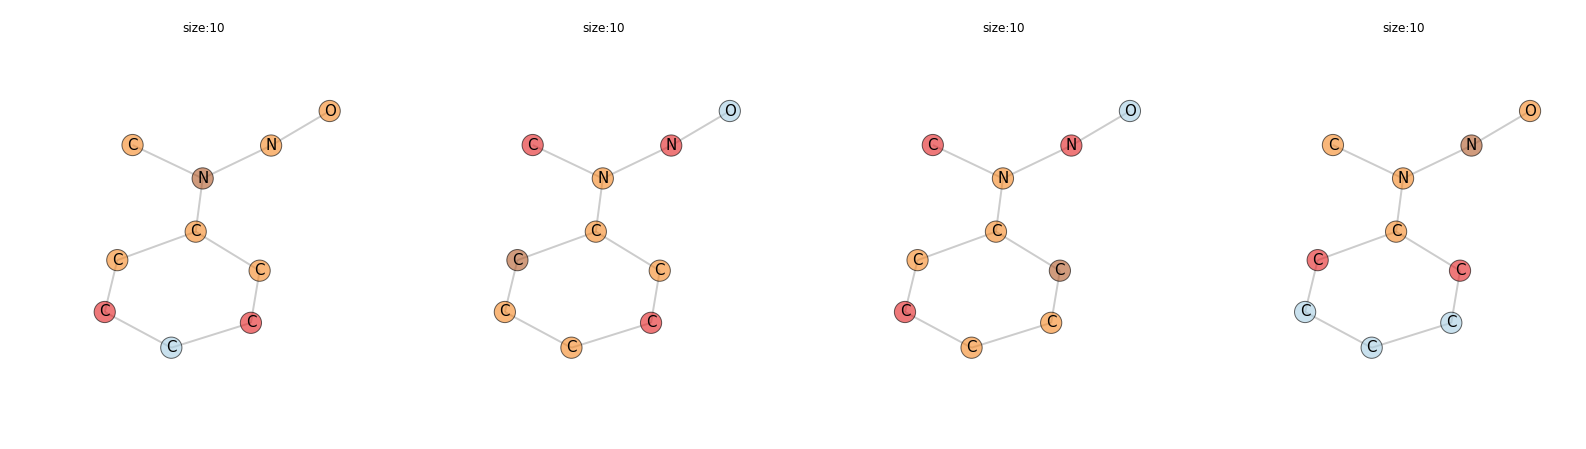

In [5]:
'''
demonstrating more extract core
'''
%matplotlib inline
import sys
sys.path.append('..')
import os
os.nice(20)
from eden.converter.graph.gspan import gspan_to_eden
import graphlearn.utils.draw as myutils
import eden.graph as eg
import graphlearn.graphlearn as gl

#get 5 grtaphs...
gr = gspan_to_eden( 'bursi.pos.gspan' )
for x in range (5):
    g=gr.next()
    # for each, pick 5 cores and extract cips 
    nice_graphs=[]
    for n in range(5):
        node=n
        a=gl.extract_core_and_interface(node,g,radius_list=[3],thickness_list=[1],vectorizer=eg.Vectorizer())
        # draw cip on the original graph and save in nice_graphs
        nice_graphs+=myutils.cip_to_graph(a, graphs=[g,g]) 
        
    # draw nice_graphs
    myutils.draw_graph_set(nice_graphs, 
                           n_graphs_per_line=7, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=1,
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)


Classifier:
SGDClassifier(alpha=0.000978084457185, average=False, class_weight=None,
       epsilon=0.1, eta0=0.734938544025, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=70, n_jobs=1,
       penalty='l1', power_t=0.613480097803, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
interface: 655375


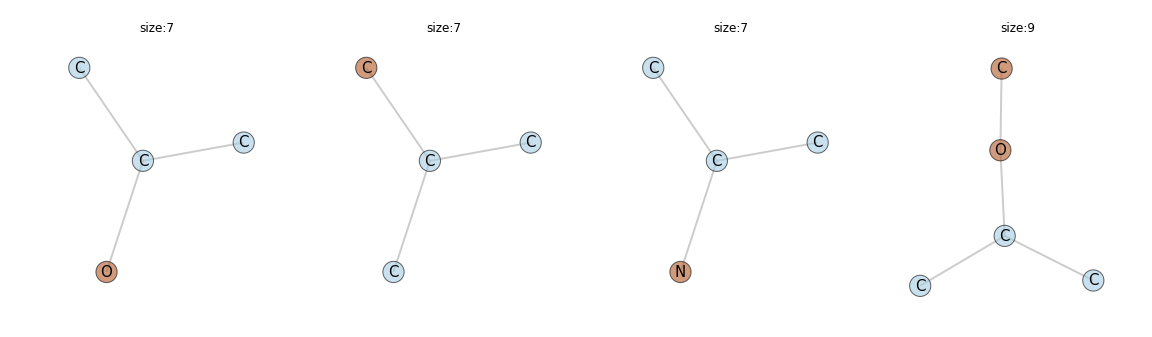

interface: 319520


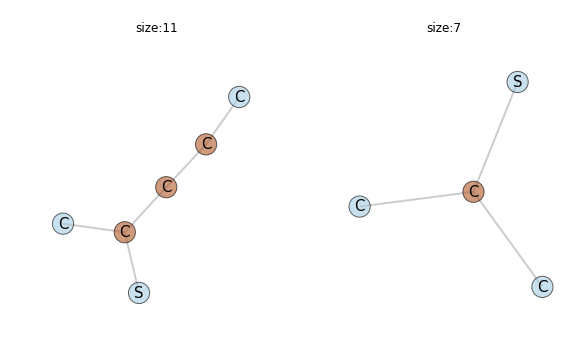

interface: 696607


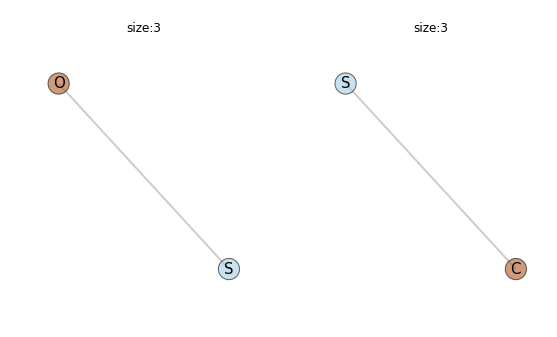

interface: 90437


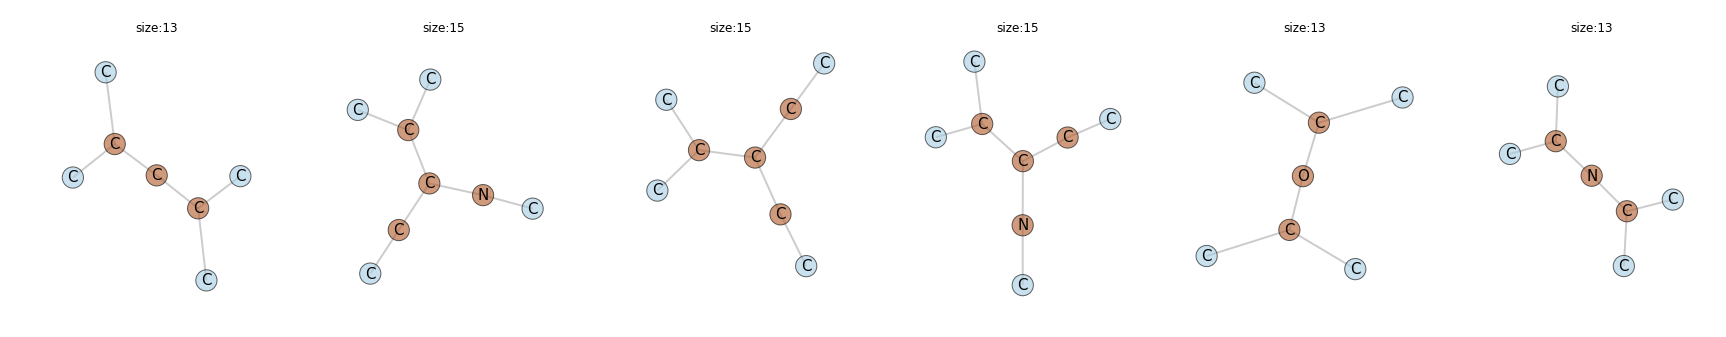

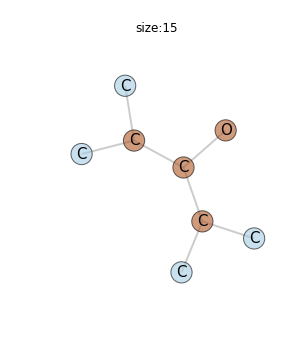

interface: 754249


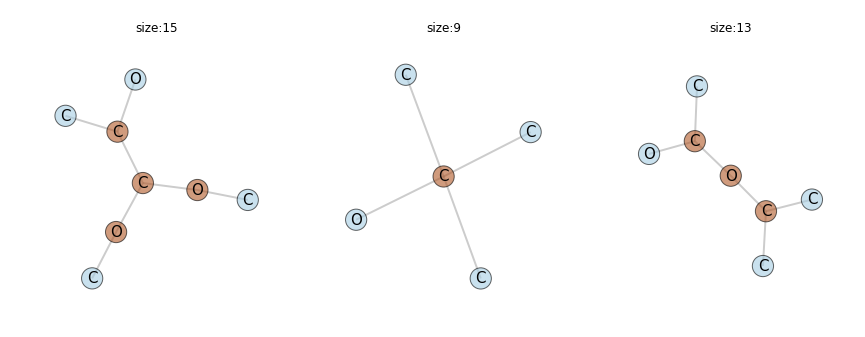

CPU times: user 9.26 s, sys: 973 ms, total: 10.2 s
Wall time: 14.4 s


In [6]:
%%time
'''
second is reading a grammar and training an estimator
'''
import sys
sys.path.append('..')
import os 
os.nice(20)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
gr = gspan_to_eden( 'bursi.pos.gspan' )

# we just learn a grammar from 50 graphs..  
gr = itertools.islice(gr,100)
sampler=gl.GraphLearnSampler()
#sampler=sampler.load('tmp/demo.ge')
sampler.fit(gr,n_jobs=-1)

# we look at the estimator and  draw 5 interfaces with their associated cores
#print sampler.estimator
sampler.save('tmp/demo.ge')
myutils.draw_grammar(sampler.local_substitutable_graph_grammar.grammar,n_productions=5,
                     n_graphs_per_line=6, size=5, 
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

how often do we see interfacehashes
# productions: 367
x = # interfaces (total: 99)
y=numberofcores(ihash), y=sumOfCoreCounts(ihash)


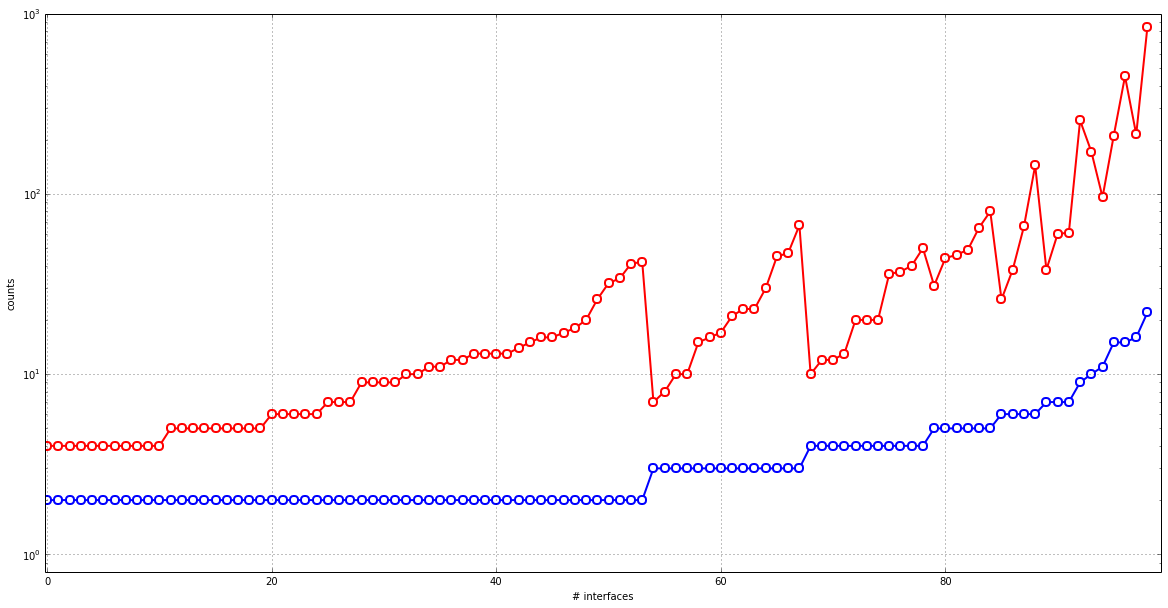

how often was this corehash seen?
x = # cores (total: 57)
y = inYinterfaces(chash), y= sumOfCountOverAllInterfaces(chash)


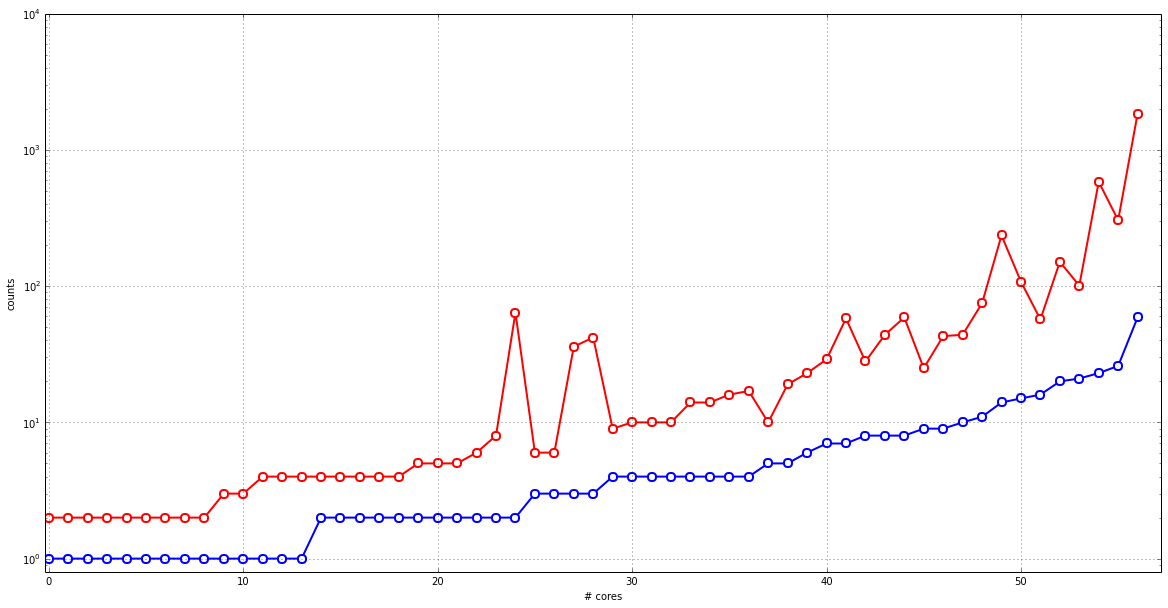

histogram
# productions: 367
distinct cores: 57 (seen on x axis)
interfaces with x many cores were observed y many times. 


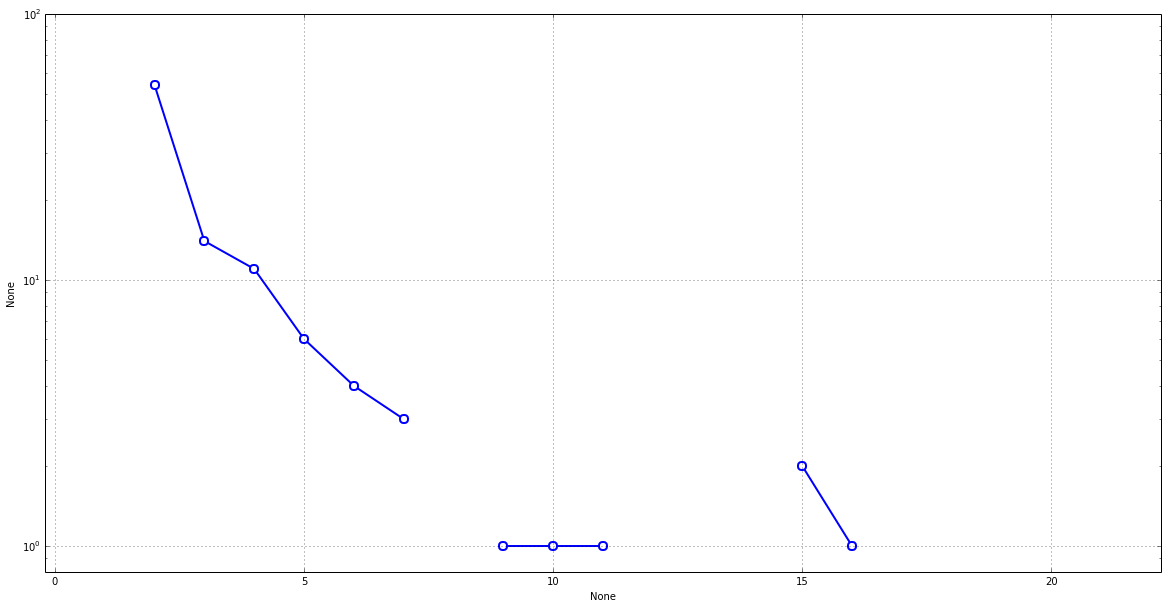

In [7]:
# here we look at some stats.
myutils.draw_grammar_stats(sampler.local_substitutable_graph_grammar.grammar, size=(20,10))

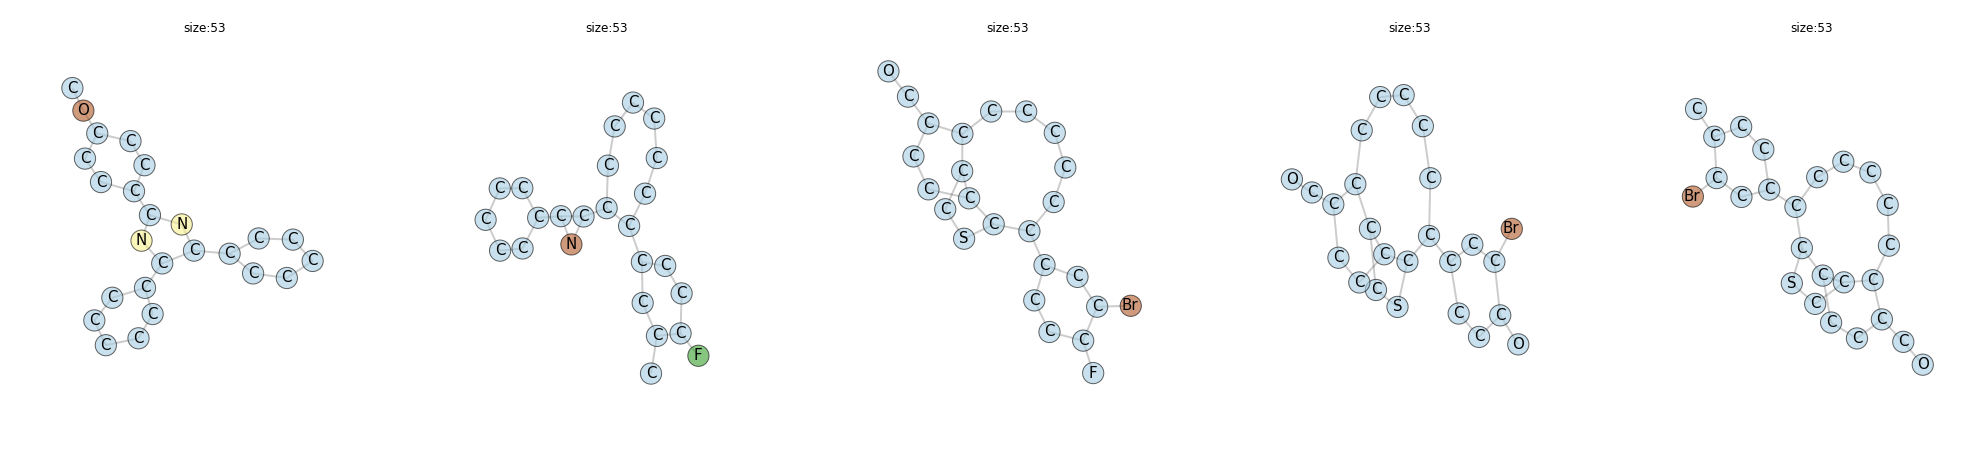

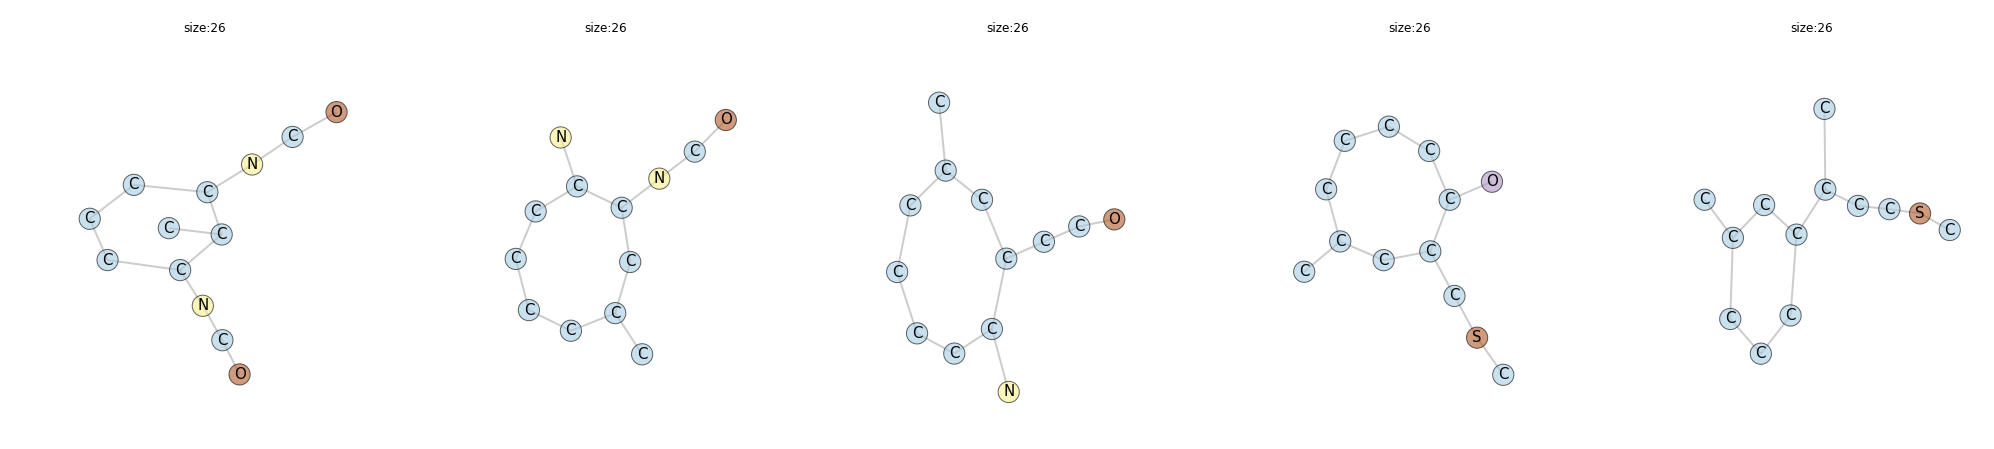

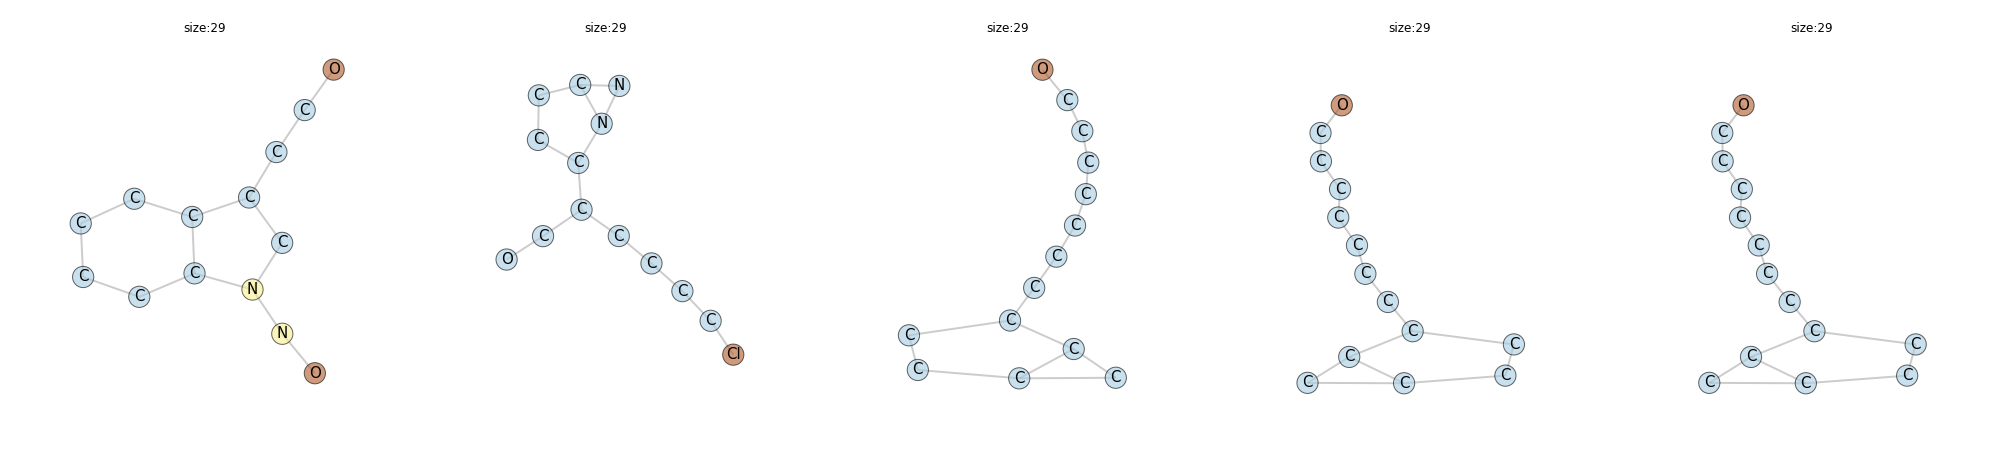

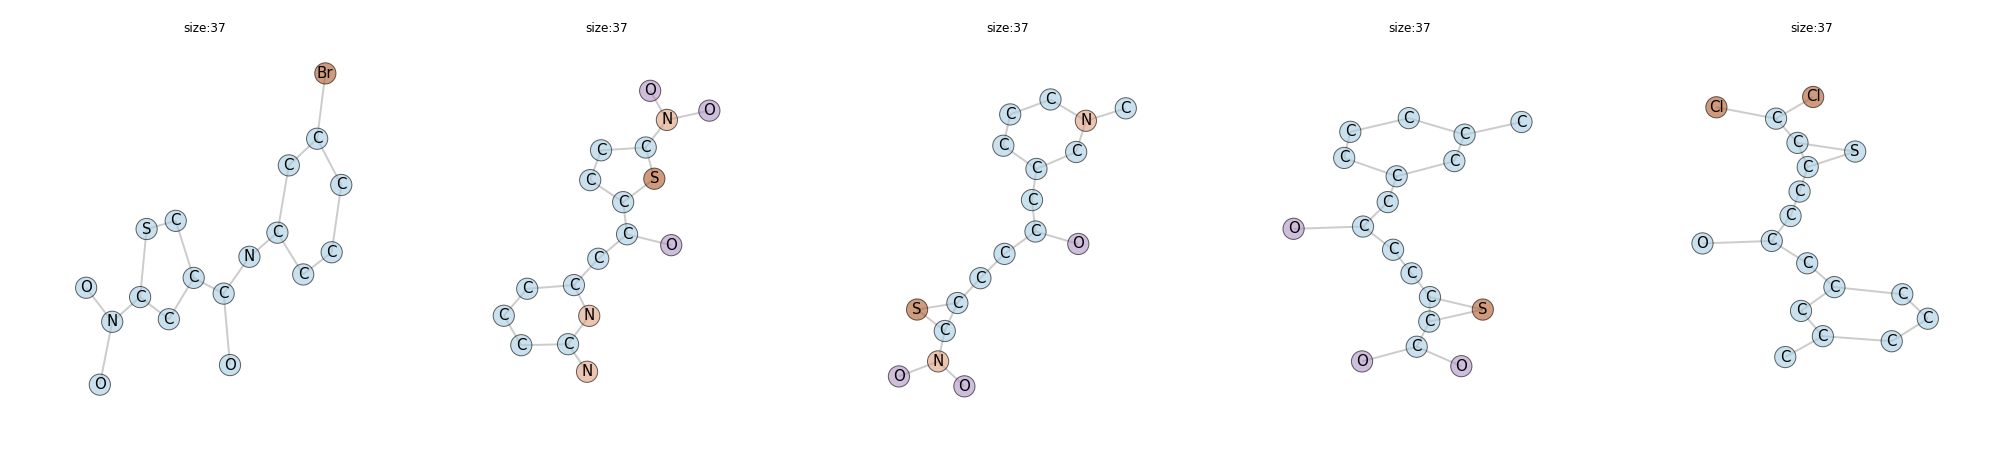

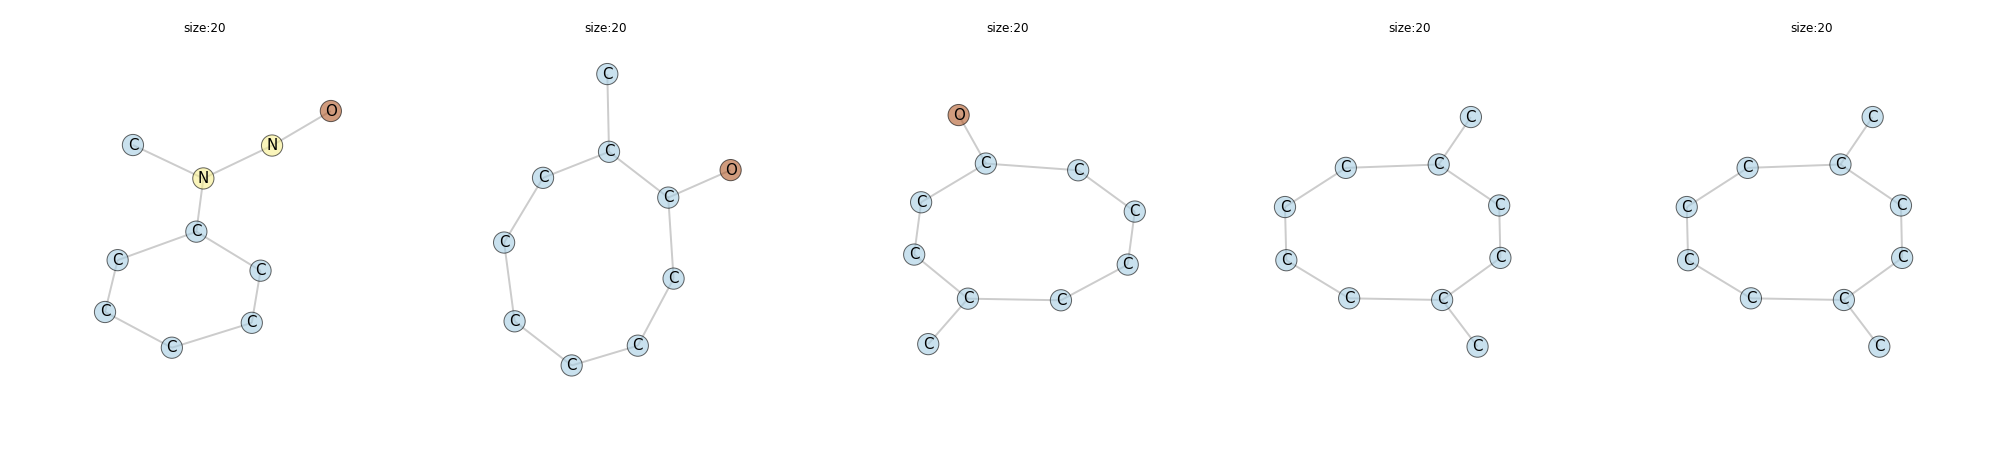

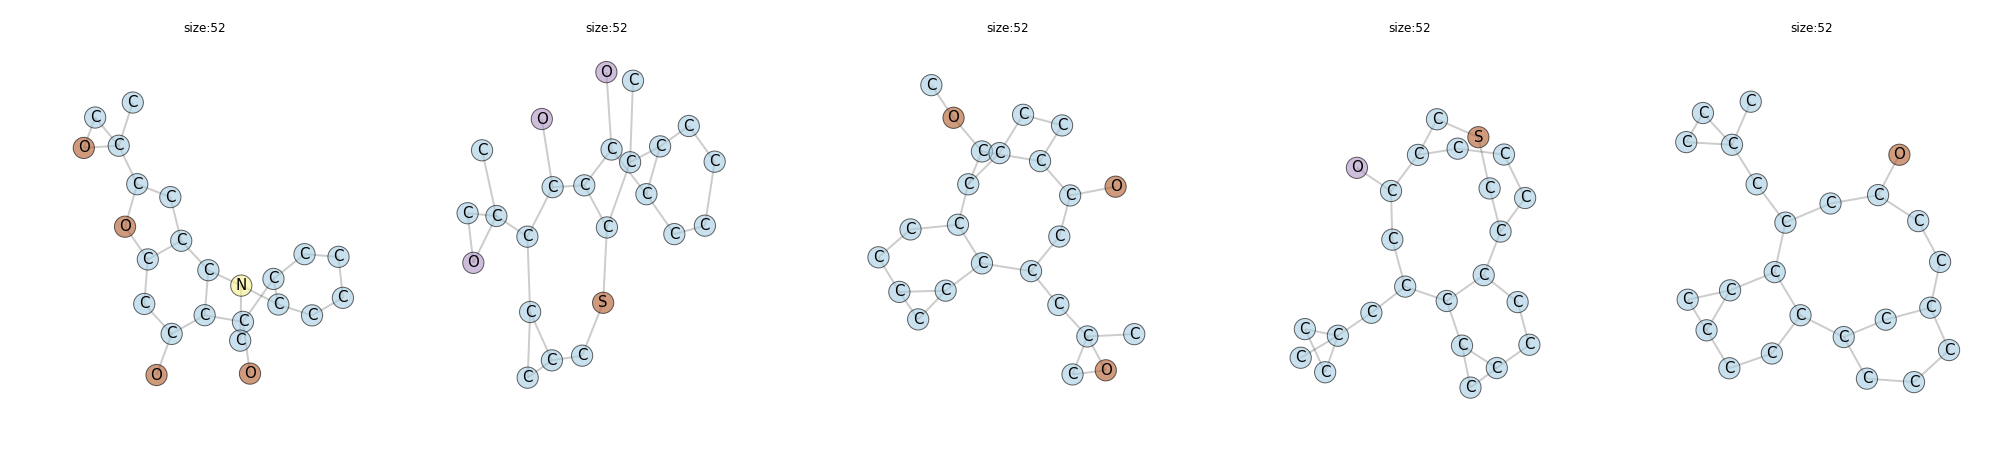

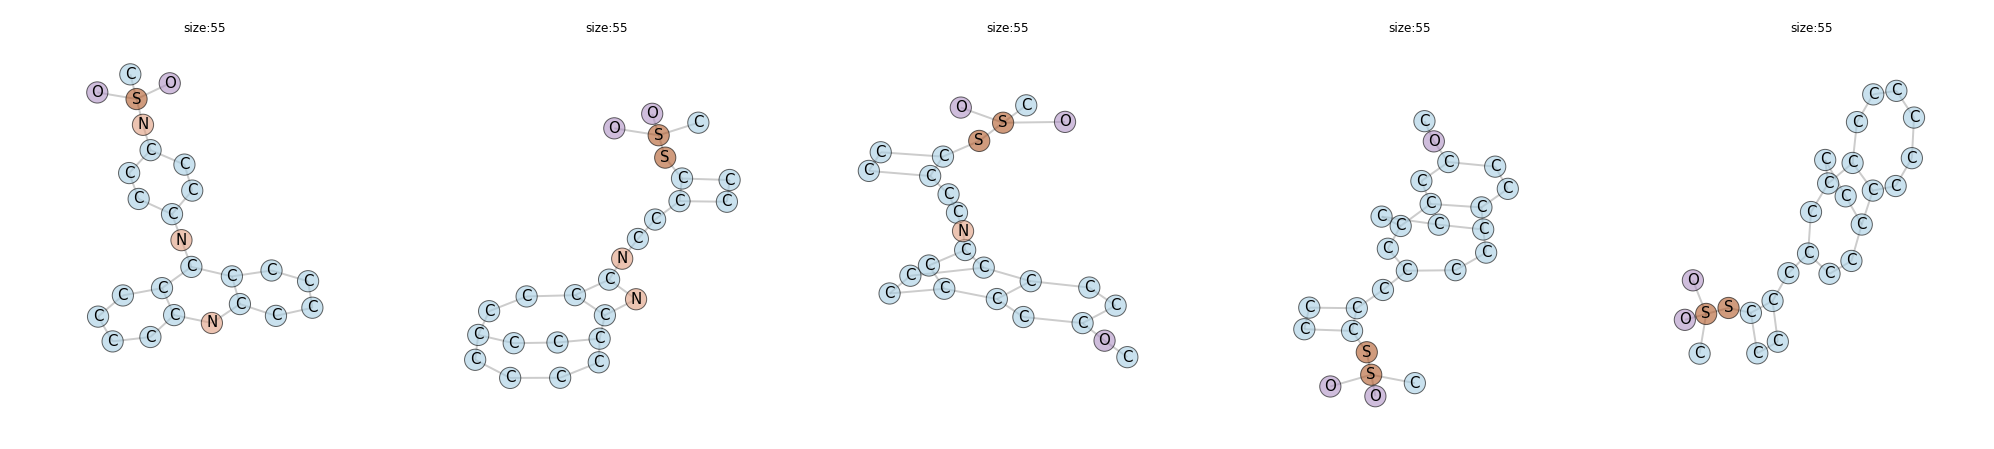

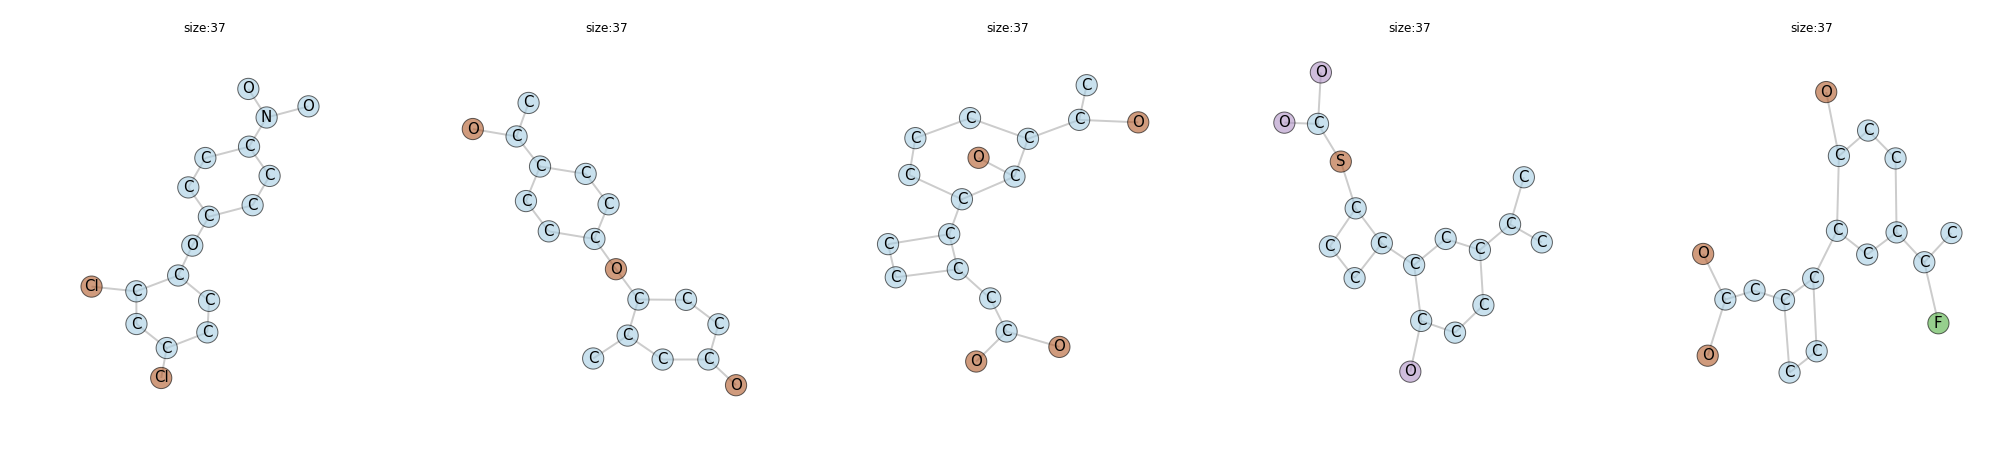

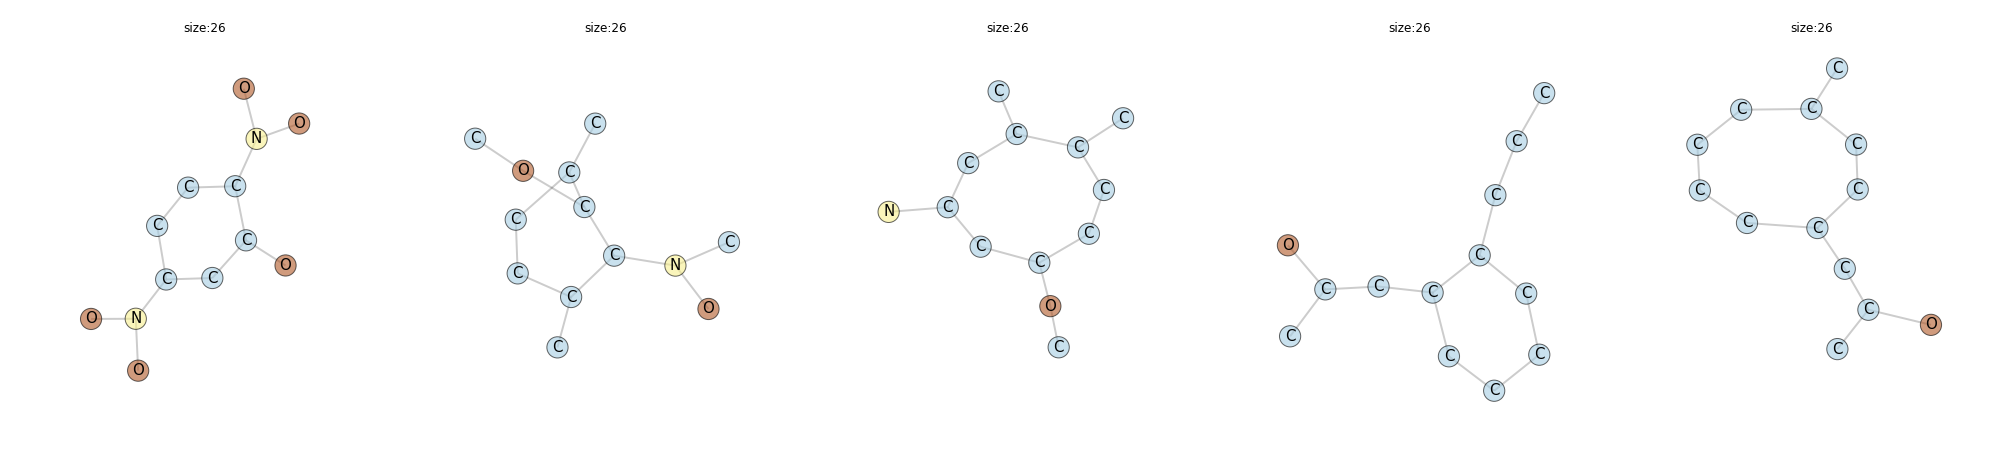

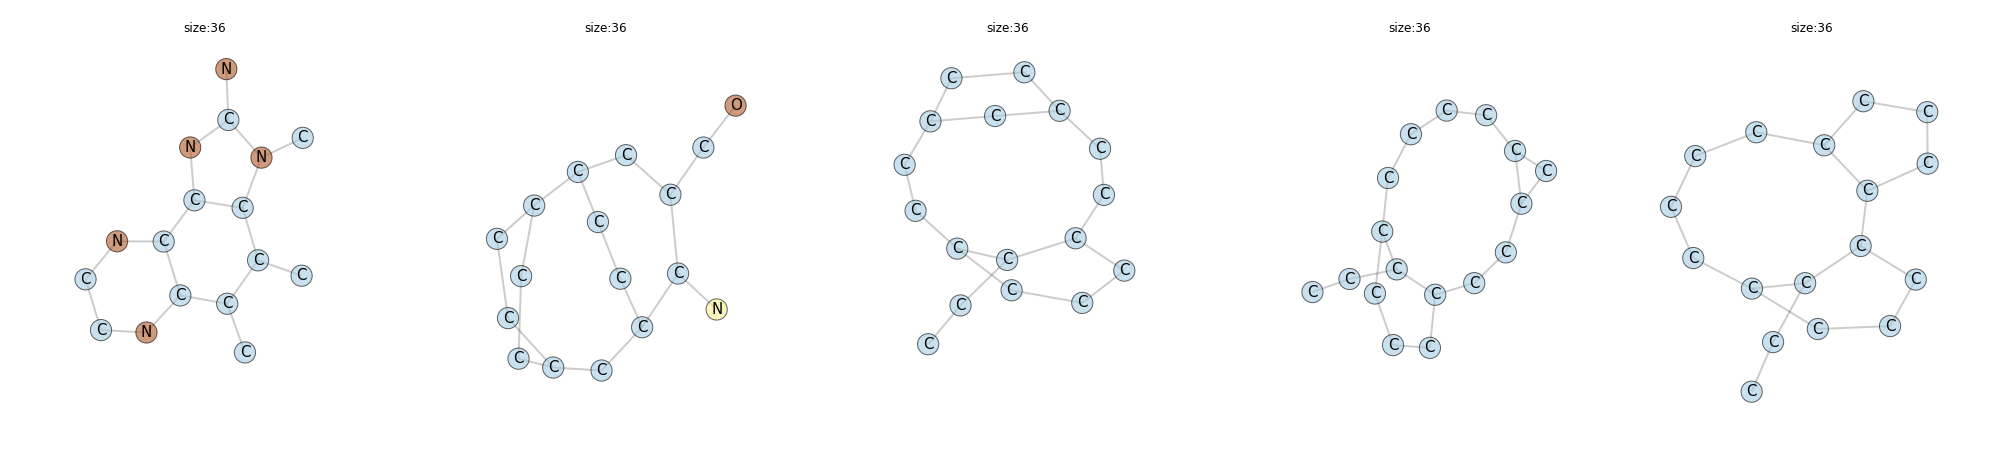

In [60]:
#%%time
'''
now lets see if we can improve graphs
'''
import sys
sys.path.append('..')
import os
os.nice(19)
%matplotlib inline
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import matplotlib.pyplot as plt
import graphlearn.utils.draw as myutils
import eden.graph as ge


'''
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,9)
sampler=gl.GraphLearnSampler( vectorizer=ge.Vectorizer(normalization=False,inner_normalization=False))
sampler.fit(graphs,n_jobs=-1)
sampler.save('tmp/demo_nonorm.ge')
'''

#sampler.load('tmp/demo_nonorm.ge')
graphs = gspan_to_eden( 'bursi.pos.gspan' )
graphs = itertools.islice(graphs,0,10)
n_steps=100
graphs = sampler.sample(graphs,
                        same_radius=False,
                        same_core_size=True,
                        sampling_interval=int(n_steps/4)+1,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        annealing_factor=1.5,
                        probabilistic_core_choice=True)
history=[]
for  i, (result,info) in enumerate(graphs):
    history.append(info['score_history'])
    myutils.draw_graph_set(info['graphs'], 
                           n_graphs_per_line=6, size=7, 
                           colormap='Paired', invert_colormap=False,node_border=1, vertex_color='_labels_',
                           vertex_alpha=0.6, edge_alpha=0.2, node_size=450)

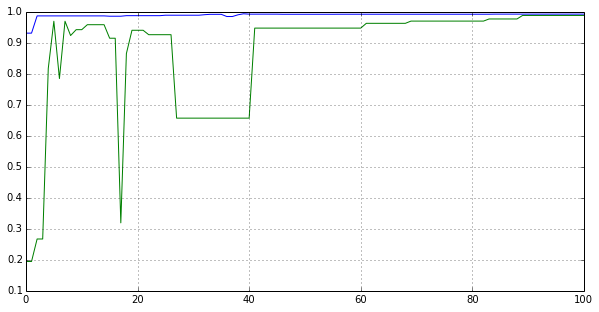

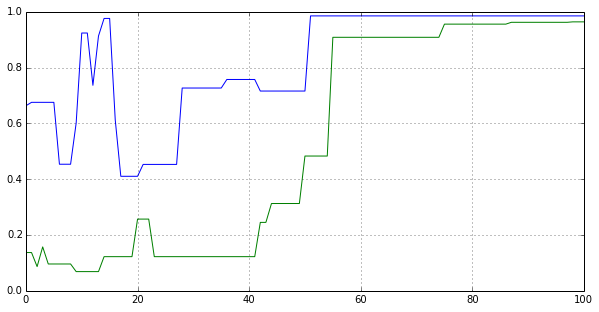

In [61]:
%matplotlib inline
num_graphs_per_plot=4
delta=len(history)/num_graphs_per_plot
for i in range(delta):
    plt.figure(figsize=(10,5))
    for h in history[i*delta:(i+1)*delta]:
        plt.plot(h)
    plt.grid()
    plt.show()